# 6 - CLUSTERING K-MEANS

**AUTOR: Fabrizio Ramirez Cutimbo**

**OBJETIVOS:**

+ Aplicar la técnica de clustering K-means a los dataset preprocesados.
+ Evaluar el número Optimo de Clusters en función de inercia y Silueta
+ Visualizar los clusters generados. 
---

In [1]:
import pandas as pd
import numpy as np

# Graficos
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

In [2]:
pd_companias = pd.read_csv('Datasets Procesados/directorio_empresas_final_PCA.csv', dtype={'RUC': 'object'})

In [3]:
shape_inicial = pd_companias.shape
print(f'Tamaño inicial del dataset: {shape_inicial}')
pd_companias.sample(2)

Tamaño inicial del dataset: (37884, 87)


,EXPEDIENTE,RUC,SITUACION_LEGAL,FECHA_CONSTITUCION,TIPO,PAIS,REGION,PROVINCIA,CANTON,CIUDAD,...,CIIU_NIVEL_1_N,REGION_COSTA,REGION_GALÁPAGOS,REGION_ORIENTE,REGION_SIERRA,SEGMENTO_ENCODED,Set10_PCA1,Set10_PCA2,Set10_REGION_PCA1,Set10_REGION_PCA2
34015,734639,2091766038001,ACTIVA,20/01/2021,ANÓNIMA,ECUADOR,GALÁPAGOS,GALAPAGOS,SANTA CRUZ,PUERTO AYORA,...,1.0,0.0,1.0,0.0,0.0,3,0.126296,-0.026395,0.425453,-0.038170
24951,344733,1793204352001,ACTIVA,14/02/2023,SOCIEDAD POR ACCIONES SIMPLIFICADA,ECUADOR,SIERRA,PICHINCHA,QUITO,QUITO,...,0.0,0.0,0.0,0.0,1.0,2,-0.688319,0.107093,-0.564819,0.006453


In [4]:
pd_companias.columns

Index(['EXPEDIENTE', 'RUC', 'SITUACION_LEGAL', 'FECHA_CONSTITUCION', 'TIPO',
       'PAIS', 'REGION', 'PROVINCIA', 'CANTON', 'CIUDAD', 'CIIU_NIVEL_1',
       'CIIU_NIVEL_1_DESC', 'CIIU_NIVEL_3', 'CIIU_NIVEL_3_DESC',
       'CIIU_NIVEL_4', 'CIIU_NIVEL_4_DESC', 'CIIU_NIVEL_6',
       'CIIU_NIVEL_6_DESC', 'ACTIVO_2022', 'ACTIVO_CORRIENTE_2022',
       'INVENTARIOS_2022', 'ACTIVOS_NO_CORRIENTES_2022', 'PASIVO_2022',
       'PASIVO_CORRIENTE_2022', 'PASIVO_NO_CORRIENTE_2022',
       'PATRIMONIO_NETO_2022', 'INGRESOS_ACTIVIDADES_ORDINARIAS_2022',
       'GANANCIA_BRUTA_2022', 'OTROS_INGRESOS_2022',
       'COSTO_VENTAS_PRODUCCION_2022', 'GASTOS_2022',
       'UTILIDAD_OPERATIVA_2022', 'GANACIA_PERDIDA_ANTES_IR_2022',
       'IMPUESTO_RENTA_2022', 'UTILIDAD_NETA_2022', 'ACTIVO_2023',
       'ACTIVO_CORRIENTE_2023', 'INVENTARIOS_2023',
       'ACTIVOS_NO_CORRIENTES_2023', 'PASIVO_2023', 'PASIVO_CORRIENTE_2023',
       'PASIVO_NO_CORRIENTE_2023', 'PATRIMONIO_NETO_2023',
       'INGRESOS_ACTIVID

## EVALUACIÓN Nro CLUSTERS 

**INERCIA**: suma de las distancias cuadradas entre cada punto de datos y el centroide del clúster al que pertenece.
- Entre menor inercia mejor agrupamiento
- No penaliza el sobreajuste: Si aumentas el número de clústeres la inercia siempre disminuirá
- Determinar el número óptimo de clústeres. 
- Se utiliza comúnmente con el método del codo (elbow method), donde se busca un punto en la gráfica donde la reducción de la inercia disminuye drásticamente.

**SILUETA**
Es una métrica que mide qué tan bien separados y cohesionados están los clústeres generados por un algoritmo de agrupamiento, como K-Means. Es útil para evaluar la calidad del agrupamiento y determinar si los datos se agrupan correctamente.
- 1: El punto está bien asignado a su clúster y es distante de otros clústeres.
- 0: El punto está en el límite entre dos clústeres, no claramente asignado.
- -1: El punto está mal asignado, ya que está más cerca de un clúster diferente.


In [5]:
def evaluar_kmeans(dataset, columnas, rango_clusters, random_state=24, n_init=10):
    """
    Evalúa la inercia y la silueta para diferentes números de clústeres en un dataset.

    Parametros:
        dataset (DataFrame): El dataset que contiene las columnas a analizar.
        columnas (list): Lista de columnas sobre las cuales se aplica K-Means.
        rango_clusters (range): Rango de valores para el número de clústeres (ej. range(10, 20)).
        random_state (int): Semilla para reproducibilidad. Default es 24.
        n_init (int): Número de inicializaciones de K-Meansm, el resultado filanl es el de mejor oputput en terminos de inercia. Default es 10.

    SAlida:
        Genera una gráfica comparativa de Inercia vs Silueta.
        dict: Contiene los tres mejores clústeres según menor inercia y mejor silueta.
    """
    inertia = []
    silhouette = []
    k_values = list(rango_clusters)

    for k in rango_clusters:
        kmeans = KMeans(n_clusters=k, random_state=24, n_init=n_init)
        labels = kmeans.fit_predict(dataset[columnas])
        
        # Calcular inercia
        inertia.append(kmeans.inertia_)
        
        # Calcular silueta (solo si k > 1)
        if k > 1:
            silhouette_avg = silhouette_score(dataset[columnas], labels)
        else:
            silhouette_avg = np.nan
        
        silhouette.append(silhouette_avg)

    # Seleccionar los tres mejores clústeres por inercia (método del codo)
    top_inertia = sorted(zip(k_values, inertia), key=lambda x: x[1])[:3]
    # Seleccionar los tres mejores clústeres por silueta
    top_silhouette = sorted(zip(k_values, silhouette), key=lambda x: x[1], reverse=True)[:3]

    # Crear una gráfica para comparar las métricas
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(k_values, inertia, 'g-', label="Inercia")
    ax2.plot(k_values, silhouette, 'b-', label="Silueta", marker='o')

    ax1.set_xlabel('Número de Clusters')
    ax1.set_ylabel('Inercia', color='g')
    ax2.set_ylabel('Silhouette', color='b')

    plt.title('Inercia y Silhouette VS. Número de Clusters')
    plt.show()

    return {
        "mejores_inercia": top_inertia,
        "mejores_silueta": top_silhouette
    }

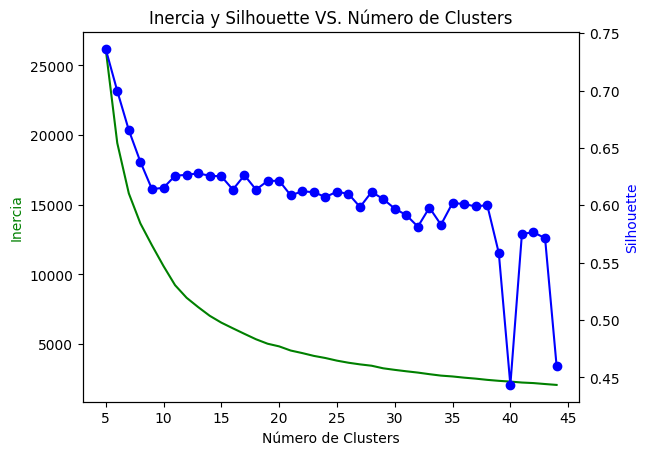

In [7]:
# Evaluación del dataset general
resultados_set10 = evaluar_kmeans(
    dataset=pd_companias, 
    columnas=['Set10_PCA1', 'Set10_PCA2'], 
    rango_clusters=range(5, 45)
)

In [8]:
## En la segunda iteración, SE DESCARTA la validación por región

# resultados_set10_region_sierra = evaluar_kmeans(
#     dataset=pd_companias[pd_companias['REGION']=='SIERRA'], 
#     columnas=['Set10_REGION_PCA1', 'Set10_REGION_PCA2'], 
#     rango_clusters=range(5, 50)
# )

# resultados_set10_region_costa = evaluar_kmeans(
#     dataset=pd_companias[pd_companias['REGION']=='COSTA'],
#     columnas=['Set10_REGION_PCA1', 'Set10_REGION_PCA2'], 
#     rango_clusters=range(5, 50)
# )

# resultados_set10_region_oriente = evaluar_kmeans(
#     dataset=pd_companias[pd_companias['REGION']=='ORIENTE'],
#     columnas=['Set10_REGION_PCA1', 'Set10_REGION_PCA2'], 
#     rango_clusters=range(2, 30)
# )

# resultados_set10_region_galapagos = evaluar_kmeans(
#     dataset=pd_companias[pd_companias['REGION']=='GALÁPAGOS'],
#     columnas=['Set10_REGION_PCA1', 'Set10_REGION_PCA2'], 
#     rango_clusters=range(2, 30)
# )

In [9]:
# print('Métricas Set 10')
# print("Top 3 silueta:", resultados_set10_region_sierra['mejores_silueta'])

# print('Métricas Set Región 10')
# print("Top 3 silueta:", resultados_set10_region_sierra['mejores_silueta'])
# print("Top 3 silueta:", resultados_set10_region_costa['mejores_silueta'])
# print("Top 3 silueta:", resultados_set10_region_oriente['mejores_silueta'])
# print("Top 3 silueta:", resultados_set10_region_galapagos['mejores_silueta'])

### Seleccionar los mejores números clusters

Resultados_set10
- 20

Resultados_set10_region
- Sierra: 27 
- Costa: 26 
- Oriente: 10
- Galapagos: 11

In [6]:
# Resultados_set10
k_clusters = 20


# Resultados_set10_region
k_sierra = 25
k_costa = 25
k_oriente = 12
k_galapagos = 10

In [7]:
def clusterizacion_algoritmo_kmeans(dataset, columnas, n_clusters, columna_salida, sufijo='', random_state=24, n_init=10):
    """
    Aplica el modelo KMeans a un DataFrame y agrega una columna con los clusters asignados.

    Parameters:
    dataset (pd.DataFrame): El DataFrame sobre el cual se aplicará KMeans.
    columnas (list): Lista de nombres de las columnas para realizar el clustering.
    n_clusters (int): Número de clusters a generar.
    random_state (int): Semilla para reproducibilidad.
    n_init (int): Número de inicializaciones para el algoritmo.
    sufijo (str): Sufijo que se agregará al nombre de la columna de clusters.

    Returns:
    pd.DataFrame: DataFrame con una nueva columna para los clusters asignados.
    """
    # Crear una copia del DataFrame para evitar problemas de vistas
    dataset = dataset.copy()

    # Crear el modelo KMeans
    model = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=n_init)

    # Ajustar el modelo con las columnas seleccionadas
    model.fit(dataset[columnas])

    # Calcular métricas
    inercia = model.inertia_  # WCSS
    silueta = silhouette_score(dataset[columnas], model.labels_) if n_clusters > 1 else None

    # Agregar los clusters al DataFrame y añadir el sufijo si se proporciona
    if sufijo:
        dataset[columna_salida] = [f"{cluster}_{sufijo}" for cluster in model.labels_]
    else:
        dataset[columna_salida] = model.labels_

    return dataset, model.cluster_centers_, silueta, inercia

### Generación Clusters Global por Set10

silhouette_score: 0.6214216300667759
inertia: 4832.014079023619


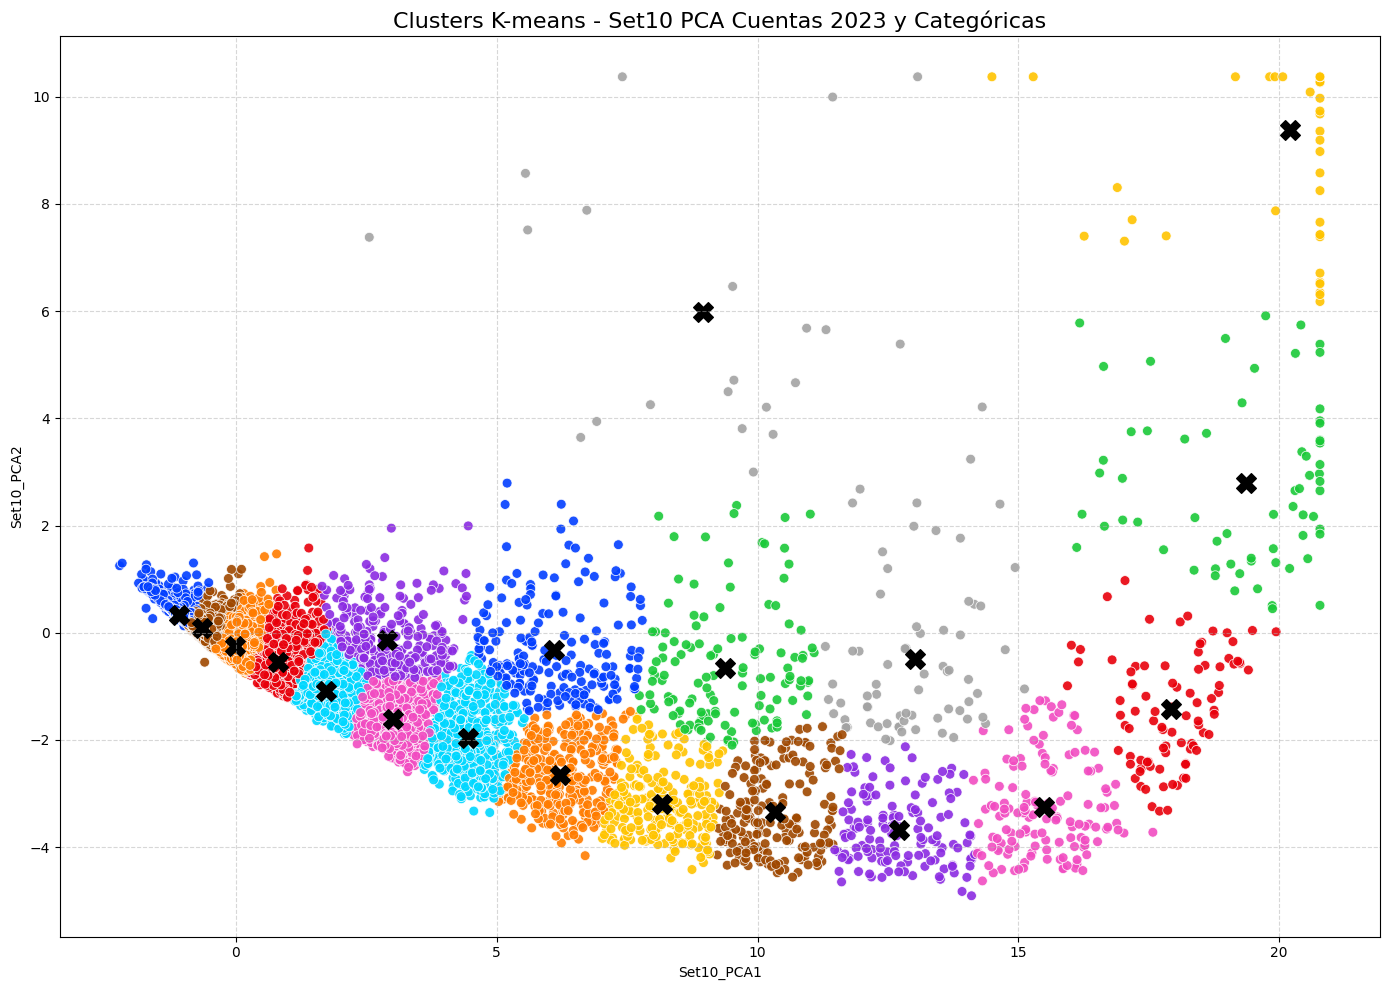

In [8]:
pd_companias_pca_set_10_kmeans_clustered, centroids, silueta, inercia  = clusterizacion_algoritmo_kmeans(pd_companias, columnas=['Set10_PCA1', 'Set10_PCA2'], n_clusters=k_clusters, columna_salida='CLUSTERS_KMEANS_SET_10', sufijo='')

print(f'silhouette_score: {silueta}')
print(f'inertia: {inercia}')

# Crear el color palette para los clusters con colores más saturados
colores = sns.color_palette("bright", k_clusters)

# Crear figura
plt.figure(figsize=(14, 10))

# Graficar los puntos de los clusters
sns.scatterplot(
    x='Set10_PCA1', y='Set10_PCA2', 
    hue='CLUSTERS_KMEANS_SET_10', palette=colores, 
    data=pd_companias_pca_set_10_kmeans_clustered, 
    s=50, alpha=0.9, legend=True
)

# Graficar los centroides
plt.scatter(centroids[:, 0], centroids[:, 1], color="black", marker="X", s=200, label="Centroides")

# Personalizar título y diseño
plt.title('Clusters K-means - Set10 PCA Cuentas 2023 y Categóricas', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Clusters", fontsize=12, title_fontsize=13)
plt.gca().get_legend().set_visible(False) # Ocultar leyenda si se requiere

# Mostrar el gráfico
plt.tight_layout()
plt.show()

### Generación Clusters separados por regiones
NOTA: No es util cuando  se quiere realizar calculos de LQ

In [9]:
pd_companias_pca_set_10_region_sierra, centroids_sierra, silueta, inercia  = clusterizacion_algoritmo_kmeans(pd_companias[pd_companias['REGION']=='SIERRA'], columnas=['Set10_REGION_PCA1', 'Set10_REGION_PCA2'], n_clusters=k_sierra, columna_salida='CLUSTERS_KMEANS_SET_10_REGION', sufijo='sierra')
pd_companias_pca_set_10_region_costa, centroids_costa, silueta, inercia = clusterizacion_algoritmo_kmeans(pd_companias[pd_companias['REGION']=='COSTA'], columnas=['Set10_REGION_PCA1', 'Set10_REGION_PCA2'], n_clusters=k_costa, columna_salida='CLUSTERS_KMEANS_SET_10_REGION', sufijo='costa')
pd_companias_pca_set_10_region_oriente, centroids_oriente, silueta, inercia = clusterizacion_algoritmo_kmeans(pd_companias[pd_companias['REGION']=='ORIENTE'], columnas=['Set10_REGION_PCA1', 'Set10_REGION_PCA2'], n_clusters=k_oriente, columna_salida='CLUSTERS_KMEANS_SET_10_REGION', sufijo='oriente')
pd_companias_pca_set_10_region_galapagos, centroids_galapagos, silueta, inercia = clusterizacion_algoritmo_kmeans(pd_companias[pd_companias['REGION']=='GALÁPAGOS'], columnas=['Set10_REGION_PCA1', 'Set10_REGION_PCA2'], n_clusters=k_galapagos, columna_salida='CLUSTERS_KMEANS_SET_10_REGION', sufijo='galapagos')


C:\Users\fabrizio\AppData\Local\Temp\ipykernel_20404\373130361.py:31: UserWarning: The palette list has more values (25) than needed (12), which may not be intended.
  sns.scatterplot(
C:\Users\fabrizio\AppData\Local\Temp\ipykernel_20404\373130361.py:42: UserWarning: The palette list has more values (25) than needed (10), which may not be intended.
  sns.scatterplot(


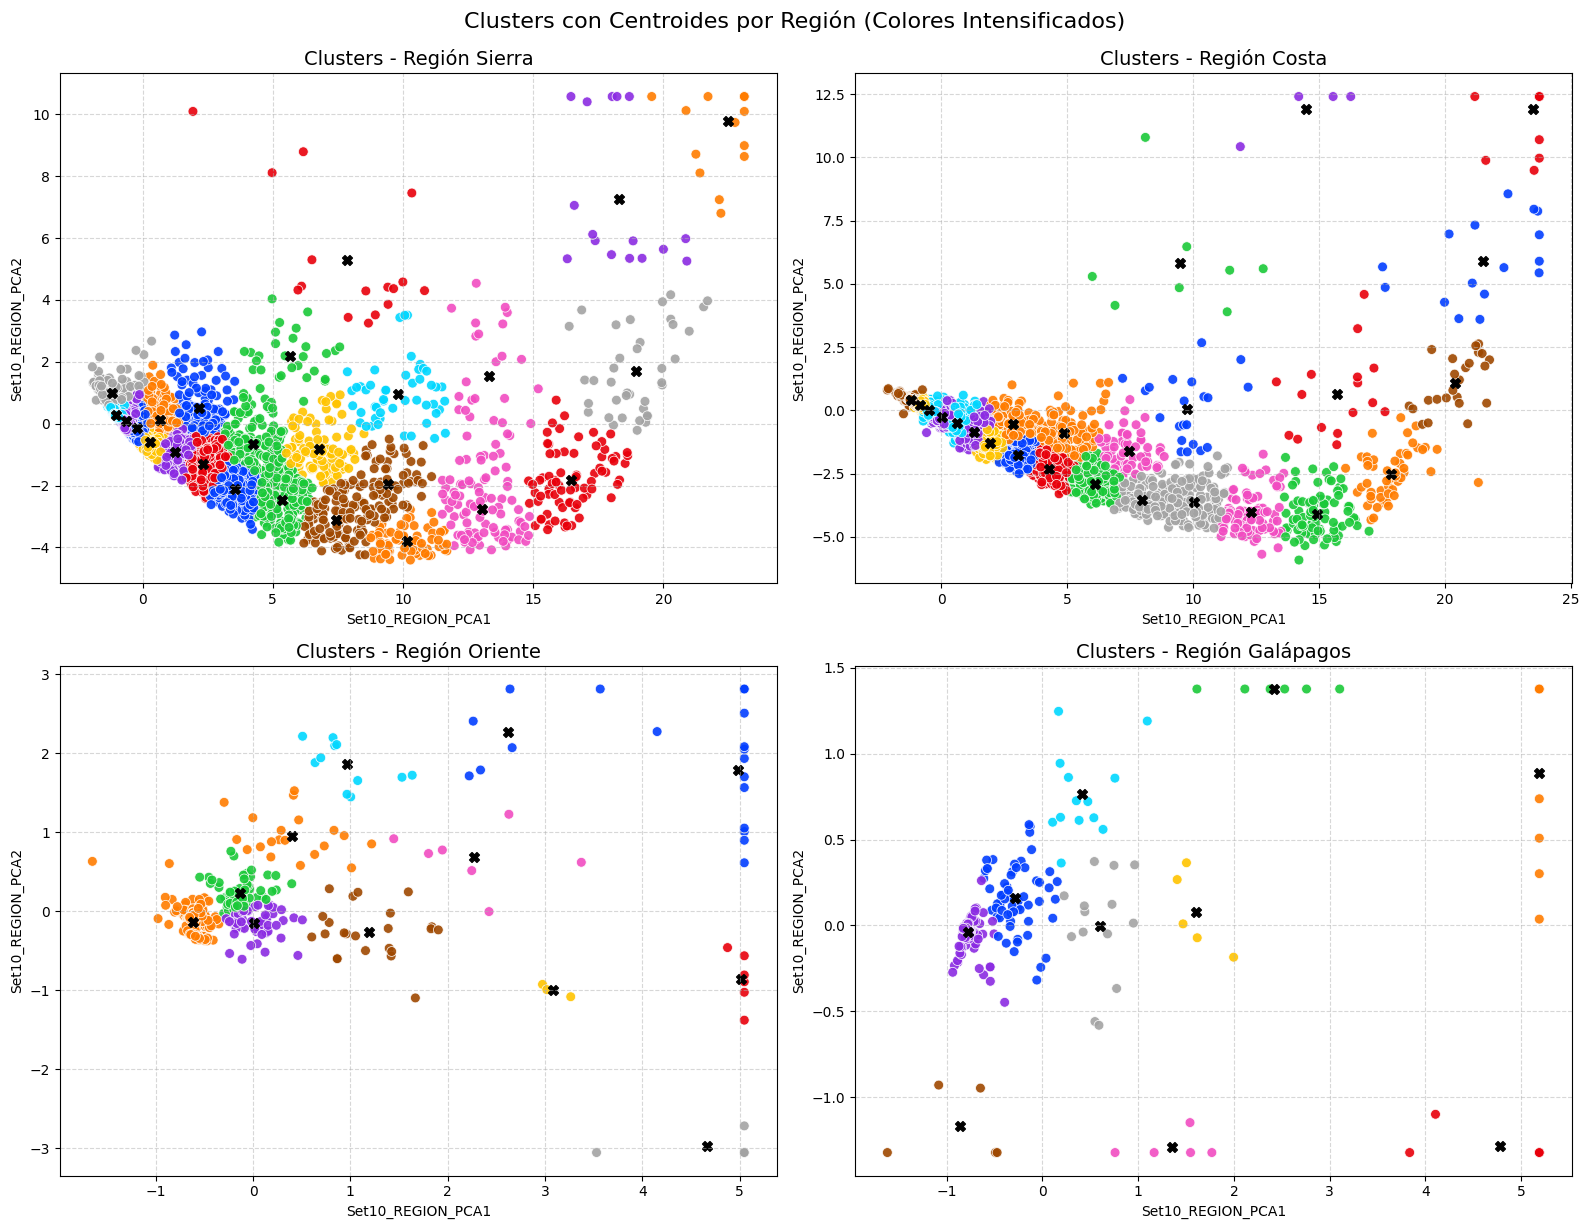

In [10]:
# Crear el color palette para los clusters con colores más saturados
n_clusters_max = max(k_sierra, k_sierra, k_sierra, k_sierra)  # Asegura el máximo número de clusters posibles
colores = sns.color_palette("bright", n_clusters_max)

# Crear figura y subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Region SIERRA
sns.scatterplot(
    x='Set10_REGION_PCA1', y='Set10_REGION_PCA2', 
    hue='CLUSTERS_KMEANS_SET_10_REGION', palette=colores, 
    data=pd_companias_pca_set_10_region_sierra, 
    ax=axes[0, 0], s=50, alpha=0.9, legend=False
)
axes[0, 0].scatter(centroids_sierra[:, 0], centroids_sierra[:, 1], color="black", marker="X", s=50)
axes[0, 0].set_title('Clusters - Región Sierra', fontsize=14)
axes[0, 0].grid(True, linestyle='--', alpha=0.5)

# Region COSTA
sns.scatterplot(
    x='Set10_REGION_PCA1', y='Set10_REGION_PCA2', 
    hue='CLUSTERS_KMEANS_SET_10_REGION', palette=colores, 
    data=pd_companias_pca_set_10_region_costa, 
    ax=axes[0, 1], s=50, alpha=0.9, legend=False
)
axes[0, 1].scatter(centroids_costa[:, 0], centroids_costa[:, 1], color="black", marker="X", s=50)
axes[0, 1].set_title('Clusters - Región Costa', fontsize=14)
axes[0, 1].grid(True, linestyle='--', alpha=0.5)

# Region ORIENTE
sns.scatterplot(
    x='Set10_REGION_PCA1', y='Set10_REGION_PCA2', 
    hue='CLUSTERS_KMEANS_SET_10_REGION', palette=colores, 
    data=pd_companias_pca_set_10_region_oriente, 
    ax=axes[1, 0], s=50, alpha=0.9, legend=False
)
axes[1, 0].scatter(centroids_oriente[:, 0], centroids_oriente[:, 1], color="black", marker="X", s=50)
axes[1, 0].set_title('Clusters - Región Oriente', fontsize=14)
axes[1, 0].grid(True, linestyle='--', alpha=0.5)

# Region GALAPAGOS
sns.scatterplot(
    x='Set10_REGION_PCA1', y='Set10_REGION_PCA2', 
    hue='CLUSTERS_KMEANS_SET_10_REGION', palette=colores, 
    data=pd_companias_pca_set_10_region_galapagos, 
    ax=axes[1, 1], s=50, alpha=0.9, legend=False
)
axes[1, 1].scatter(centroids_galapagos[:, 0], centroids_galapagos[:, 1], color="black", marker="X", s=50)
axes[1, 1].set_title('Clusters - Región Galápagos', fontsize=14)
axes[1, 1].grid(True, linestyle='--', alpha=0.5)


plt.tight_layout()
plt.suptitle("Clusters con Centroides por Región (Colores Intensificados)", fontsize=16, y=1.02)
plt.show()

## Concatenar Clusters K-means

In [11]:
# Unificar los 3 datasets
pd_companias_pca_set_10_regions_kmeans_clustered = pd.concat(
    [
        pd_companias_pca_set_10_region_sierra,
        pd_companias_pca_set_10_region_costa,
        pd_companias_pca_set_10_region_oriente,
        pd_companias_pca_set_10_region_galapagos
    ],
    axis=0,  # Combinar filas
    ignore_index=True  # Reindexar el DataFrame Set10_PCA2
)

+ CLUSTERS_KMEANS_SET_10: Clusters generados por el algoritmo Kmeans considerando todo el datset 10 de Cuentas 2023 y Categóricas
+ (DESCARTADO) CLUSTERS_KMEANS_SET_10_REGION: Clusters generados por el algoritmo Kmeans, separado por regiones, considerando todo el datset 10 de Cuentas 2023 y Categóricas

In [12]:
print(pd_companias.shape)
pd_merged = pd_companias

pd_merged = pd.merge(pd_merged, pd_companias_pca_set_10_kmeans_clustered[['RUC','CLUSTERS_KMEANS_SET_10']], left_on='RUC', right_on='RUC', how='inner')
print(pd_merged.shape)
# pd_merged = pd.merge(pd_merged, pd_companias_pca_set_10_regions_kmeans_clustered[['RUC','CLUSTERS_KMEANS_SET_10_REGION']], left_on='RUC', right_on='RUC', how='inner')
# print(pd_merged.shape)

pd_merged.columns

(37884, 87)
(37884, 88)


Index(['EXPEDIENTE', 'RUC', 'SITUACION_LEGAL', 'FECHA_CONSTITUCION', 'TIPO',
       'PAIS', 'REGION', 'PROVINCIA', 'CANTON', 'CIUDAD', 'CIIU_NIVEL_1',
       'CIIU_NIVEL_1_DESC', 'CIIU_NIVEL_3', 'CIIU_NIVEL_3_DESC',
       'CIIU_NIVEL_4', 'CIIU_NIVEL_4_DESC', 'CIIU_NIVEL_6',
       'CIIU_NIVEL_6_DESC', 'ACTIVO_2022', 'ACTIVO_CORRIENTE_2022',
       'INVENTARIOS_2022', 'ACTIVOS_NO_CORRIENTES_2022', 'PASIVO_2022',
       'PASIVO_CORRIENTE_2022', 'PASIVO_NO_CORRIENTE_2022',
       'PATRIMONIO_NETO_2022', 'INGRESOS_ACTIVIDADES_ORDINARIAS_2022',
       'GANANCIA_BRUTA_2022', 'OTROS_INGRESOS_2022',
       'COSTO_VENTAS_PRODUCCION_2022', 'GASTOS_2022',
       'UTILIDAD_OPERATIVA_2022', 'GANACIA_PERDIDA_ANTES_IR_2022',
       'IMPUESTO_RENTA_2022', 'UTILIDAD_NETA_2022', 'ACTIVO_2023',
       'ACTIVO_CORRIENTE_2023', 'INVENTARIOS_2023',
       'ACTIVOS_NO_CORRIENTES_2023', 'PASIVO_2023', 'PASIVO_CORRIENTE_2023',
       'PASIVO_NO_CORRIENTE_2023', 'PATRIMONIO_NETO_2023',
       'INGRESOS_ACTIVID

## Generar Dataset con clusters K Means

In [13]:
pd_merged.to_csv('Datasets Procesados\\directorio_empresas_final_PCA_KMEANS.csv', index=False)

---